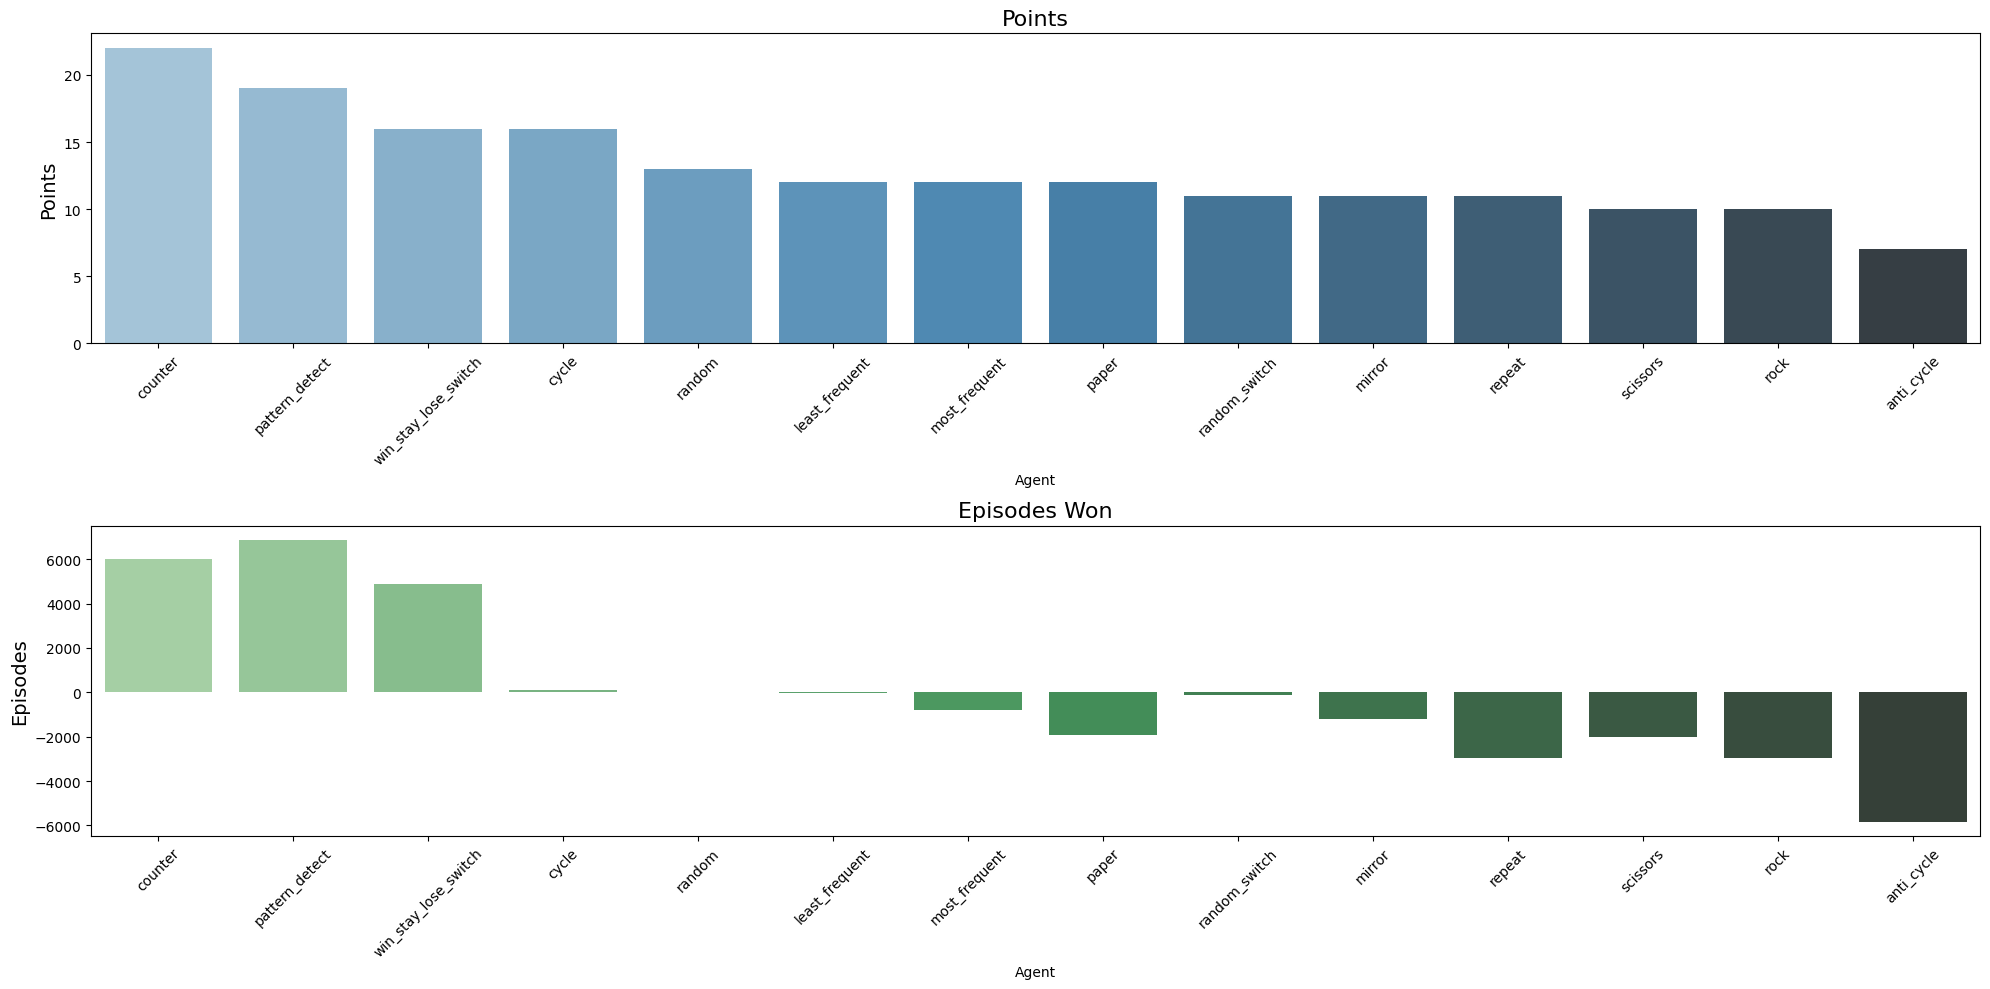

In [20]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import make, evaluate

# Базовый класс агента
class AgentBase:
    def __call__(self, observation, configuration):
        raise NotImplementedError("Implement the '__call__' method for the agent.")

# Агенты со стратегиями
class RockAgent(AgentBase):
    """Всегда выбирает камень."""
    def __call__(self, observation, configuration):
        return 0

class PaperAgent(AgentBase):
    """Всегда выбирает бумагу."""
    def __call__(self, observation, configuration):
        return 1

class ScissorsAgent(AgentBase):
    """Всегда выбирает ножницы."""
    def __call__(self, observation, configuration):
        return 2

class RandomAgent(AgentBase):
    """Выбирает ход случайным образом."""
    def __call__(self, observation, configuration):
        return random.randint(0, configuration.signs - 1)

class CycleAgent(AgentBase):
    """Последовательно выбирает камень, бумагу, ножницы."""
    def __init__(self):
        self.current = 0

    def __call__(self, observation, configuration):
        move = self.current
        self.current = (self.current + 1) % configuration.signs
        return move

class MirrorAgent(AgentBase):
    """Повторяет предыдущий ход соперника."""
    def __call__(self, observation, configuration):
        return observation.lastOpponentAction if observation.step > 0 else 0

class CounterAgent(AgentBase):
    """Играет против предыдущего хода соперника."""
    def __call__(self, observation, configuration):
        if observation.step > 0:
            return (observation.lastOpponentAction + 1) % configuration.signs
        return 0

class AntiCycleAgent(AgentBase):
    """Анализирует ход циклического агента и пытается его обыграть."""
    def __call__(self, observation, configuration):
        if observation.step == 0:
            return random.randint(0, configuration.signs - 1)
        return (observation.lastOpponentAction + 2) % configuration.signs

class RepeatAgent(AgentBase):
    """Повторяет собственный предыдущий ход."""
    def __init__(self):
        self.last_move = 0

    def __call__(self, observation, configuration):
        move = self.last_move
        self.last_move = move
        return move

class MostFrequentAgent(AgentBase):
    """Выбирает ход, побеждающий наиболее частый ход соперника."""
    def __init__(self):
        self.history = []

    def __call__(self, observation, configuration):
        if observation.step == 0:
            return random.randint(0, configuration.signs - 1)
        self.history.append(observation.lastOpponentAction)
        common_action = max(set(self.history), key=self.history.count)
        return (common_action + 1) % configuration.signs

class LeastFrequentAgent(AgentBase):
    """Выбирает ход, побеждающий наименее частый ход соперника."""
    def __init__(self):
        self.history = []

    def __call__(self, observation, configuration):
        if observation.step == 0:
            return random.randint(0, configuration.signs - 1)
        self.history.append(observation.lastOpponentAction)
        rare_action = min(set(self.history), key=self.history.count)
        return (rare_action + 1) % configuration.signs

class WinStayLoseSwitchAgent(AgentBase):
    """Сохраняет ход, если выиграл, и меняет на случайный при проигрыше."""
    def __init__(self):
        self.last_move = 0

    def __call__(self, observation, configuration):
        if observation.step > 0 and observation.reward < 0:
            self.last_move = random.randint(0, configuration.signs - 1)
        return self.last_move

class RandomSwitchAgent(AgentBase):
    """Каждый ход с вероятностью 50% меняет стратегию."""
    def __init__(self):
        self.current_agent = RandomAgent()

    def __call__(self, observation, configuration):
        if random.random() < 0.5:
            self.current_agent = random.choice([RockAgent(), PaperAgent(), ScissorsAgent()])
        return self.current_agent(observation, configuration)

class PatternDetectAgent(AgentBase):
    """Ищет повторяющиеся шаблоны в ходах соперника."""
    def __init__(self, memory=4):
        self.memory = memory
        self.history = []

    def __call__(self, observation, configuration):
        if observation.step == 0:
            return random.randint(0, configuration.signs - 1)
        self.history.append(observation.lastOpponentAction)
        if len(self.history) > self.memory:
            self.history.pop(0)
        if len(set(self.history)) == 1:
            return (self.history[0] + 1) % configuration.signs
        return random.randint(0, configuration.signs - 1)

agents = {
    'rock': RockAgent(),
    'paper': PaperAgent(),
    'scissors': ScissorsAgent(),
    'random': RandomAgent(),
    'cycle': CycleAgent(),
    'mirror': MirrorAgent(),
    'counter': CounterAgent(),
    'anti_cycle': AntiCycleAgent(),
    'repeat': RepeatAgent(),
    'most_frequent': MostFrequentAgent(),
    'least_frequent': LeastFrequentAgent(),
    'win_stay_lose_switch': WinStayLoseSwitchAgent(),
    'random_switch': RandomSwitchAgent(),
    'pattern_detect': PatternDetectAgent()
}

# Турнир
class Tournament:
    def __init__(self, agents):
        self.agents = agents
        self.results = {agent: {'episodes_sum': 0, 'points': 0} for agent in agents}

    def __save_result(self, round_result, left, right):
        left_wins, right_wins = round_result[0][0], round_result[0][1]
        self.results[left]['episodes_sum'] += left_wins
        self.results[right]['episodes_sum'] += right_wins
        if left_wins > right_wins:
            self.results[left]['points'] += 2
        elif left_wins < right_wins:
            self.results[right]['points'] += 2
        else:
            self.results[left]['points'] += 1
            self.results[right]['points'] += 1

    def start(self, episodes):
        names = list(self.agents.keys())
        for i in range(len(names) - 1):
            for j in range(i + 1, len(names)):
                left, right = names[i], names[j]
                round_result = evaluate(
                    "rps",
                    [self.agents[left], self.agents[right]],
                    configuration={"episodeSteps": episodes},
                    debug=True
                )
                self.__save_result(round_result, left, right)

    def print_result(self):
      sorted_results = sorted(self.results.items(),
                              key=lambda x: (x[1]['points'], x[1]['episodes_sum']),
                              reverse=True)
      df = pd.DataFrame([{'Agent': k, 'Points': v['points'], 'Episodes': v['episodes_sum']}
                        for k, v in sorted_results])

      fig, axes = plt.subplots(2, 1, figsize=(20, 10))

      sns.barplot(data=df, x='Agent', y='Points', ax=axes[0], hue='Agent', dodge=False, palette="Blues_d", legend=False)
      axes[0].set_title("Points", fontsize=16)
      axes[0].set_ylabel("Points", fontsize=14)
      axes[0].tick_params(axis='x', rotation=45)

      sns.barplot(data=df, x='Agent', y='Episodes', ax=axes[1], hue='Agent', dodge=False, palette="Greens_d", legend=False)
      axes[1].set_title("Episodes Won", fontsize=16)
      axes[1].set_ylabel("Episodes", fontsize=14)
      axes[1].tick_params(axis='x', rotation=45)

      plt.tight_layout()
      plt.show()


# Структура турнира:
# Каждый агент играет против каждого другого по 1000 раундов.
# Результаты матчей фиксируются:
# За победу в раунде агент получает очко.
# Очки за победы складываются в общем зачёте.
# Дополнительно начисляются турнирные очки: 2 очка за победу в матче, 1 очко за ничью.
# Подсчёт результатов:

# Визуализация результатов:
# Построены две диаграммы:
# Турнирные очки для каждого агента.
# Общее количество выигранных раундов.

# Запуск турнира
tournament = Tournament(agents)
tournament.start(1000)
tournament.print_result()
